In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sparse_wf.system import database

In [2]:
import jax
from jax.scipy.linalg import solve

In [3]:
A = jax.random.normal(jax.random.key(4), (4096, 4096))
b = jax.random.normal(jax.random.key(5), (4096,))
A = A + A.T

2024-10-16 10:22:36.408532: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [6]:
%timeit jax.block_until_ready(jax.jit(solve)(A, b))

26.2 ms ± 240 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%timeit jax.block_until_ready(jax.jit(lambda A, b: solve(A, b, assume_a="pos"))(A, b))

71.7 ms ± 2.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [2]:
from pyscf import cc
from sparse_wf.scf import CASWavefunction, run_cas
mol = database(comment='cumulene_C8H4_90deg')
# mol.basis = 'aug-cc-pVDZ'
# mol.build()
# mf = mol.RHF().run()
# mycc = cc.CCSD(mf).run()
# et = mycc.ccsd_t()
# print('CCSD(T) total energy', mycc.e_tot + et)

In [3]:
mol.spin = 2
mol.build()
mol.nelec

(27, 25)

In [7]:
import numpy as np
def confs_from_mc(mc, tol: float = 0):
    r"""Retrieve the electronic configurations contributing to a pyscf CAS-SCF solution.

    Args:
        mc: a pyscf MC-SCF object.
        tol (float): default 0, the CI weight threshold.

    Returns:
        list: coefficients of the configurations
        list: the list of configurations
    """
    conf_coeff, *confs = zip(
        *mc.fcisolver.large_ci(mc.ci, mc.ncas, mc.nelecas, tol=tol, return_strs=False)
    )
    confs = [
        [
            np.tile(np.arange(int(mc.ncore)), (len(conf_coeff), 1)),
            np.array(cfs) + mc.ncore,
        ]
        for cfs in confs
    ]
    confs = np.concatenate([np.concatenate(cfs, axis=-1) for cfs in confs], axis=-1)
    order = np.argsort(np.abs(conf_coeff))[::-1]
    conf_coeff = np.array(conf_coeff)[order]
    confs = confs[order]
    return conf_coeff, confs

In [15]:
import pyscf
wf = CASWavefunction(mol, 16, 4, 4, 0.0, -1)
cas = pyscf.mcscf.CASCI(wf.hf, 4, 4)
cas.kernel();

CASCI E = -301.101966075682  E(CI) = -2.24586952785165  S^2 = 2.0000000
CASCI E = -301.101966075682  E(CI) = -2.24586952785165  S^2 = 2.0000000


In [19]:
wf.idx_orbitals[np.argsort(np.abs(wf.ci_coeffs))[::-1]]

Array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 26,  0,  1,  2,  3,  4,  5,
         6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 27],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25,  0,  1,  2,  3,  4,  5,
         6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 26],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25,  0,  1,  2,  3,  4,  5,
         6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 25, 27],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 27,  0,  1,  2,  3,  4,  5,
         6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 25, 27],
       [ 0,  1,  2,  3,  4,  5,  6, 

In [16]:
confs_from_mc(cas)[0][:16]

array([ 0.70227406, -0.70227406,  0.06253404, -0.06253404, -0.04823523,
        0.04823523, -0.02336569,  0.02336569, -0.00405897,  0.00405897,
        0.00259364, -0.00259364,  0.0016913 , -0.0016913 ,  0.00140937,
       -0.00140937])

In [17]:
wf.ci_coeffs[np.argsort(np.abs(wf.ci_coeffs))[::-1]]

Array([-7.0227408e-01,  7.0227408e-01, -6.2534042e-02, -4.8235234e-02,
        4.8235234e-02,  2.3365691e-02,  2.5936402e-03, -1.8538351e-08,
        1.5898088e-08,  3.2087895e-09,  2.2543485e-09,  1.9044666e-09,
       -1.9044664e-09, -7.2078370e-15,  2.3740182e-15,  1.1186292e-15],      dtype=float32)

In [11]:
confs_from_mc(cas)[1][:16]

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25,  0,  1,  2,  3,  4,  5,
         6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 26],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 26,  0,  1,  2,  3,  4,  5,
         6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 25],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 26, 27,  0,  1,  2,  3,  4,  5,
         6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 26],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 26,  0,  1,  2,  3,  4,  5,
         6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 26, 27],
       [ 0,  1,  2,  3,  4,  5,  6, 

In [10]:
((0.08836*8)**2) * 2

0.9993586687999999

In [8]:
wf.ci_coeffs

Array([-0.08836369, -0.08836369, -0.08836369, -0.08836369, -0.08836369,
       -0.08836369, -0.08836369, -0.08836369,  0.08836369,  0.08836369,
        0.08836369,  0.08836369,  0.08836369,  0.08836369,  0.08836369,
        0.08836369], dtype=float32)

In [7]:
wf.idx_orbitals

Array([[0, 1, 2, 3, 4, 5, 6, 8, 0, 1, 2, 3, 4, 5, 6, 7],
       [0, 1, 2, 3, 4, 5, 6, 8, 0, 1, 2, 3, 4, 5, 6, 7],
       [0, 1, 2, 3, 4, 5, 6, 8, 0, 1, 2, 3, 4, 5, 6, 7],
       [0, 1, 2, 3, 4, 5, 6, 8, 0, 1, 2, 3, 4, 5, 6, 7],
       [0, 1, 2, 3, 4, 5, 6, 8, 0, 1, 2, 3, 4, 5, 6, 7],
       [0, 1, 2, 3, 4, 5, 6, 8, 0, 1, 2, 3, 4, 5, 6, 7],
       [0, 1, 2, 3, 4, 5, 6, 8, 0, 1, 2, 3, 4, 5, 6, 7],
       [0, 1, 2, 3, 4, 5, 6, 8, 0, 1, 2, 3, 4, 5, 6, 7],
       [0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 8],
       [0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 8],
       [0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 8],
       [0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 8],
       [0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 8],
       [0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 8],
       [0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 8],
       [0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 8]], dtype=int32)

In [3]:
mol.basis = 'sto-6g'
mol.build()

In [15]:
import pyscf

mf = pyscf.scf.RHF(mol)
mf.kernel()
mf.max_cycle = 0
mf.mo_coeff[0, 0] += 1
mf.init_guess = None
mf.kernel()

converged SCF energy = -77.61000176233
converged SCF energy = -111.180648130813


-111.18064813081322

In [4]:
mol.basis = 'sto-6g'
mol.build()
for _ in range(100):
    mf = mol.RHF()
    mf.run()


converged SCF energy = -77.6100017623389
converged SCF energy = -77.6100017623477
converged SCF energy = -77.552004908161
converged SCF energy = -77.6100017623545
converged SCF energy = -77.5520049082803
converged SCF energy = -77.5520049081604
converged SCF energy = -77.610001762354
converged SCF energy = -77.5520049081602
converged SCF energy = -77.6100017623548
converged SCF energy = -77.5520049081603
converged SCF energy = -77.5520049081602
converged SCF energy = -77.6100017623342
converged SCF energy = -77.6100017623222
converged SCF energy = -77.6100017623541
converged SCF energy = -77.6100017622003
converged SCF energy = -77.5520049084705
converged SCF energy = -77.6100017623544
converged SCF energy = -77.6100017623547
converged SCF energy = -77.6100017623541
converged SCF energy = -77.5520049081622
converged SCF energy = -77.5520049081605
converged SCF energy = -77.5520049084289
converged SCF energy = -77.6100017623337
converged SCF energy = -77.5520049081944
converged SCF ener

In [7]:
mf.mo_energy

array([-11.35497121, -10.92363127,  -0.98988036,  -0.74246508,
        -0.64020382,  -0.49340776,  -0.45971484,  -0.12084034,
         0.10813887,   0.57947666,   0.71277035,   0.77266423,
         0.91672989,   0.98976834])

In [ ]:
from pyscf import cc
mol = database(comment='WG_09')
mol.basis = 'aug-cc-pVTZ'
mol.build()
mycc = cc.CCSD(mf).run()
et = mycc.ccsd_t()
print('CCSD(T) total energy', mycc.e_tot + et)


converged SCF energy = -877.708579355943
E(CCSD) = -878.9208273441767  E_corr = -1.212247988233828


KeyboardInterrupt: 

In [ ]:
from pyscf import cc
mol = database(comment='WG_09')
mol.basis = 'aug-cc-pVQZ'
mol.build()
et = mycc.ccsd_t()
print('CCSD(T) total energy', mycc.e_tot + et)

converged SCF energy = -877.708579355944


In [6]:
df1 = pd.read_csv('run_1.csv')
df2 = pd.read_csv('run_2.csv')
df3 = pd.read_csv('run_3.csv')

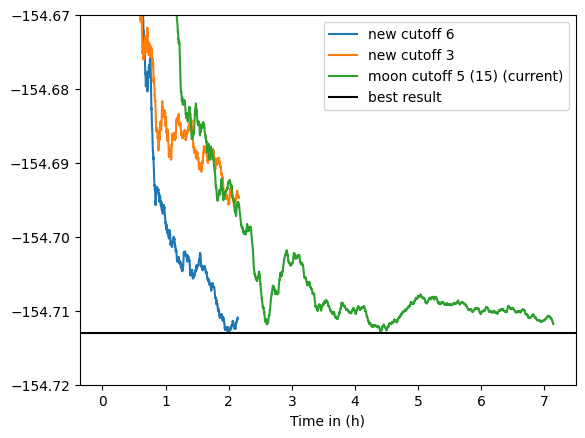

In [10]:
# plt.plot(df1['opt/step'], df1['C4H4-new-1-9.0-3-104613 - opt/E_smooth'])
plt.plot(df3['opt/step']*1.4 / 3600, df3['C4H4-new-1-6.0-9-106026 - opt/E_smooth'], label='new cutoff 6')
plt.plot(df3['opt/step']*0.96 / 3600, df3['C4H4-new-1-3.0-8-106026 - opt/E_smooth'], label='new cutoff 3')
plt.plot(df3['opt/step']*2.61 / 3600, df3['C4H4-moon-2-5.0-3-104963 - opt/E_smooth'], label='moon cutoff 5 (15) (current)')
# plt.plot(df2['Step'], df2['07-02_cumulene_C4H4_0deg_13b1974852bbdb41a3edc82b988422bf_5 - opt/E_smooth'], label='moon cutoff 5 (15) (Michael)')
plt.axhline(-154.713, color='black', label='best result')
plt.legend()
plt.xlabel('Time in (h)')
plt.ylim(-154.72, -154.67)
plt.show()

In [ ]:
from pyscf import gto, scf

# Define the molecular structure and basis set
mol = gto.M(
    atom=[('Co', 0, 0, 0),],  # Assuming 'atoms' contains the molecular geometry
    basis='ccpvdz',  # Basis set as per the paper
    spin=0,  # Assume a singlet state; modify as per the system's spin
    charge=-3,  # Adjust based on the cluster charge
    verbose=0,  # Print detailed output for debugging
    ecp='ccecp',  # Use the ECP as per the paper
)

# Perform unrestricted Hartree-Fock calculation with relativistic corrections
mf = scf.UHF(mol)  # Using unrestricted Hartree-Fock
mf.kernel()

# Print results
print("Total Energy (Hartree):", mf.e_tot)


In [18]:
-141.78415444799748

-141.78415444799748